In [1]:
from april import EventLogGenerator
from april.generation.attribute_generator import CategoricalAttributeGenerator
from april.processmining.model import ProcessMap
from april.generation.example_values import user_names, working_days, week_days

Load a process map from the `.res/process_models` directory

In [2]:
process_map = ProcessMap.from_plg('paper')

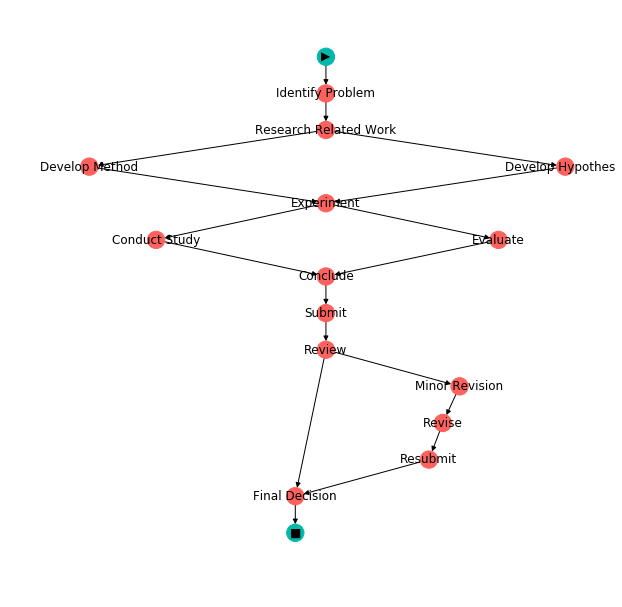

In [3]:
process_map.plot_process_map()

## Setup attributes list

In [4]:
user_names[:5]

['Roy', 'Earl', 'James', 'Charles', 'Ryan']

In [5]:
working_days

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

In [6]:
week_days

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

Now let's use the helper variables to set up two categorical event attributes.

## Setup generator
When setting up a generator we can provide a list of attributes to generate randomly. An attribute can be defined by using the class `CategoricalAttribute` and passing it some parameters. `values` specifies the allowed values for these attributes, wheras `domain` can be used to define the complete set of possible values. If `domain` is not given, the `values` array is used to set the `domain`. By defining `min_group` and `max_group` we can control how many values are chosen to be connected to an activity in the `ProcessMap`.

Here we set up two separate categorical attributes, one for the user executing the activity, and one for the days on which the user is active.

In [7]:
attributes = [CategoricalAttributeGenerator(name='user', values=user_names, min_group=1, max_group=5),
              CategoricalAttributeGenerator(name='day', values=working_days, domain=week_days, min_group=1, max_group=5)]

We can then instantiate the generator as follows.

In [8]:
generator = EventLogGenerator(process_map, event_attributes=attributes)

In [9]:
seed = 42 # We define a seed for reproducability.

## Build the likelihood graph
A likelihood graph is used to define the dependencies between activities and attributes. Let us first start with a simple example in which we do not generate any attributes.

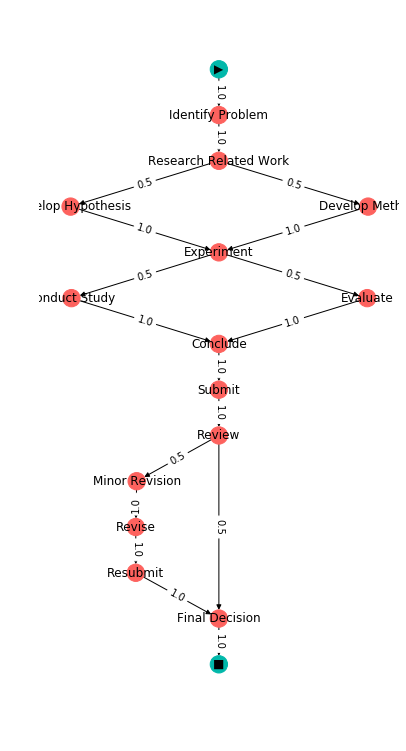

In [10]:
generator = EventLogGenerator(process_map)
likelihood_graph = generator.build_likelihood_graph(activity_dependency_p=0.0,
                                                    attribute_dependency_p=0.0,
                                                    probability_variance_max=None,
                                                    seed=seed)
generator.plot_likelihood_graph(figsize=(5, 10))

### Controlling the probabilities
We can see that the generator has automatically generated probabilities for the different activities. By changing the `probability_variance_max` parameter we can control how much variance is applied when generating these probabilities. If it is set to `None` as in the above example, a uniform distribution over all possible paths is generated.

Let us see what happens if we set it to `10`.

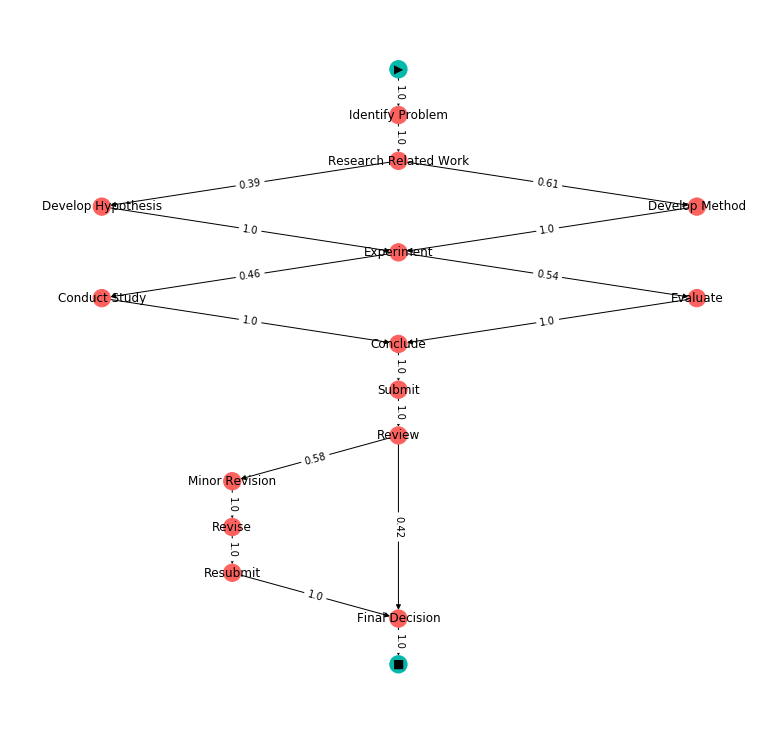

In [11]:
likelihood_graph = generator.build_likelihood_graph(activity_dependency_p=0.0,
                                                    attribute_dependency_p=0.0,
                                                    probability_variance_max=10,
                                                    seed=seed)
generator.plot_likelihood_graph(figsize=(10, 10))

Now the probabilities are sampled from a normal distribution where the variance is randomly chosen between `0` and `10`.

### Activity dependencies
Now let us have a look at the `activity_dependency_p` parameter. It control the probability of activity probabilities in the graph. If we set it to `1.0` every node that has more than one incoming edge will be split into multiple version of the same node. Resulting in a tree-like structure. Why this is important will become apparent when we look at generating the attributes.

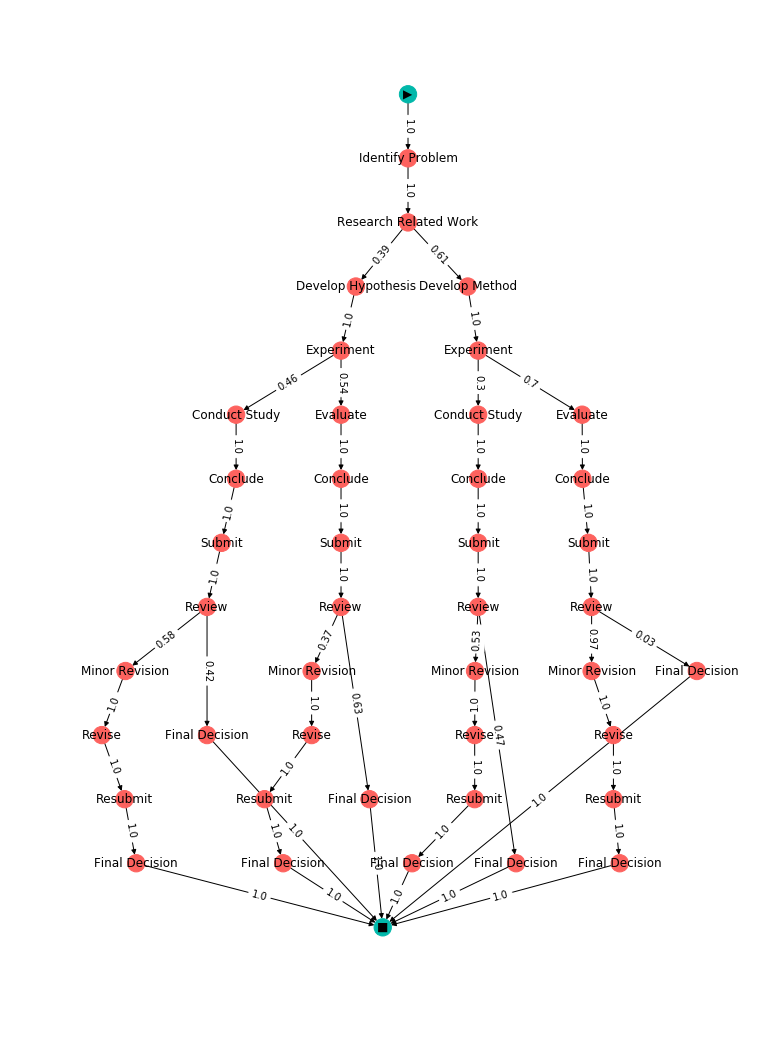

In [12]:
likelihood_graph = generator.build_likelihood_graph(activity_dependency_p=1.0,
                                                    attribute_dependency_p=0.0,
                                                    probability_variance_max=10,
                                                    seed=seed)
generator.plot_likelihood_graph(figsize=(10, 14))

Note the difference when setting `activity_dependency_p=0.5`.

### Attribute dependencies
Now let us have a look at the `attribute_dependency_p` parameter. It controls the connection between possible attribute values for an activity node. First, let us see what happens when we generate attributes, setting `activity_dependency_p=0.0` and `attribute_dependency_p=0.0`. Note that we now pass the attributes list to the generator when instantiating it.

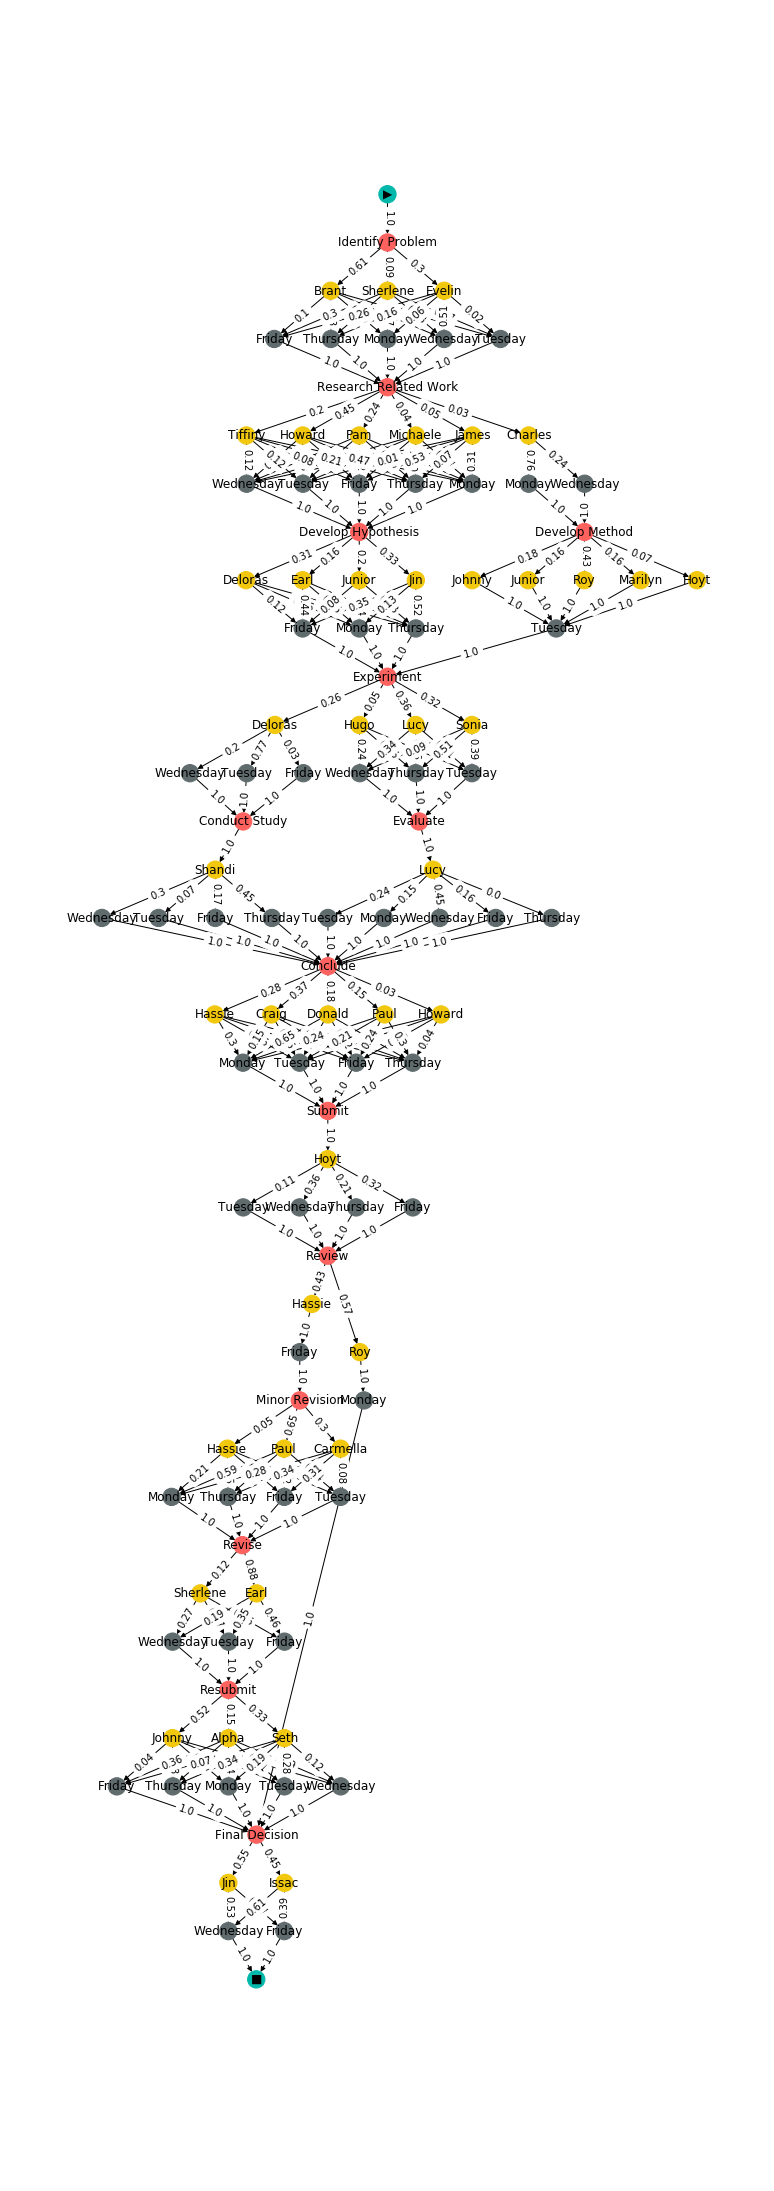

In [13]:
generator = EventLogGenerator(process_map, event_attributes=attributes)
likelihood_graph = generator.build_likelihood_graph(activity_dependency_p=0.0,
                                                    attribute_dependency_p=0.0,
                                                    probability_variance_max=10,
                                                    seed=seed)
generator.plot_likelihood_graph(figsize=(10, 30))

We can see that the generator has generated combinations of the `user` and `day` attribute. The generator will randomly chose between `min_group` and `max_group` possible values for each activity node. Here all combinations between the possible values are allowed, resulting in the fully-meshed subgraphs. We can control this by altering the `attribute_dependency_p` parameter. If we set it to `0.5` we see the difference.

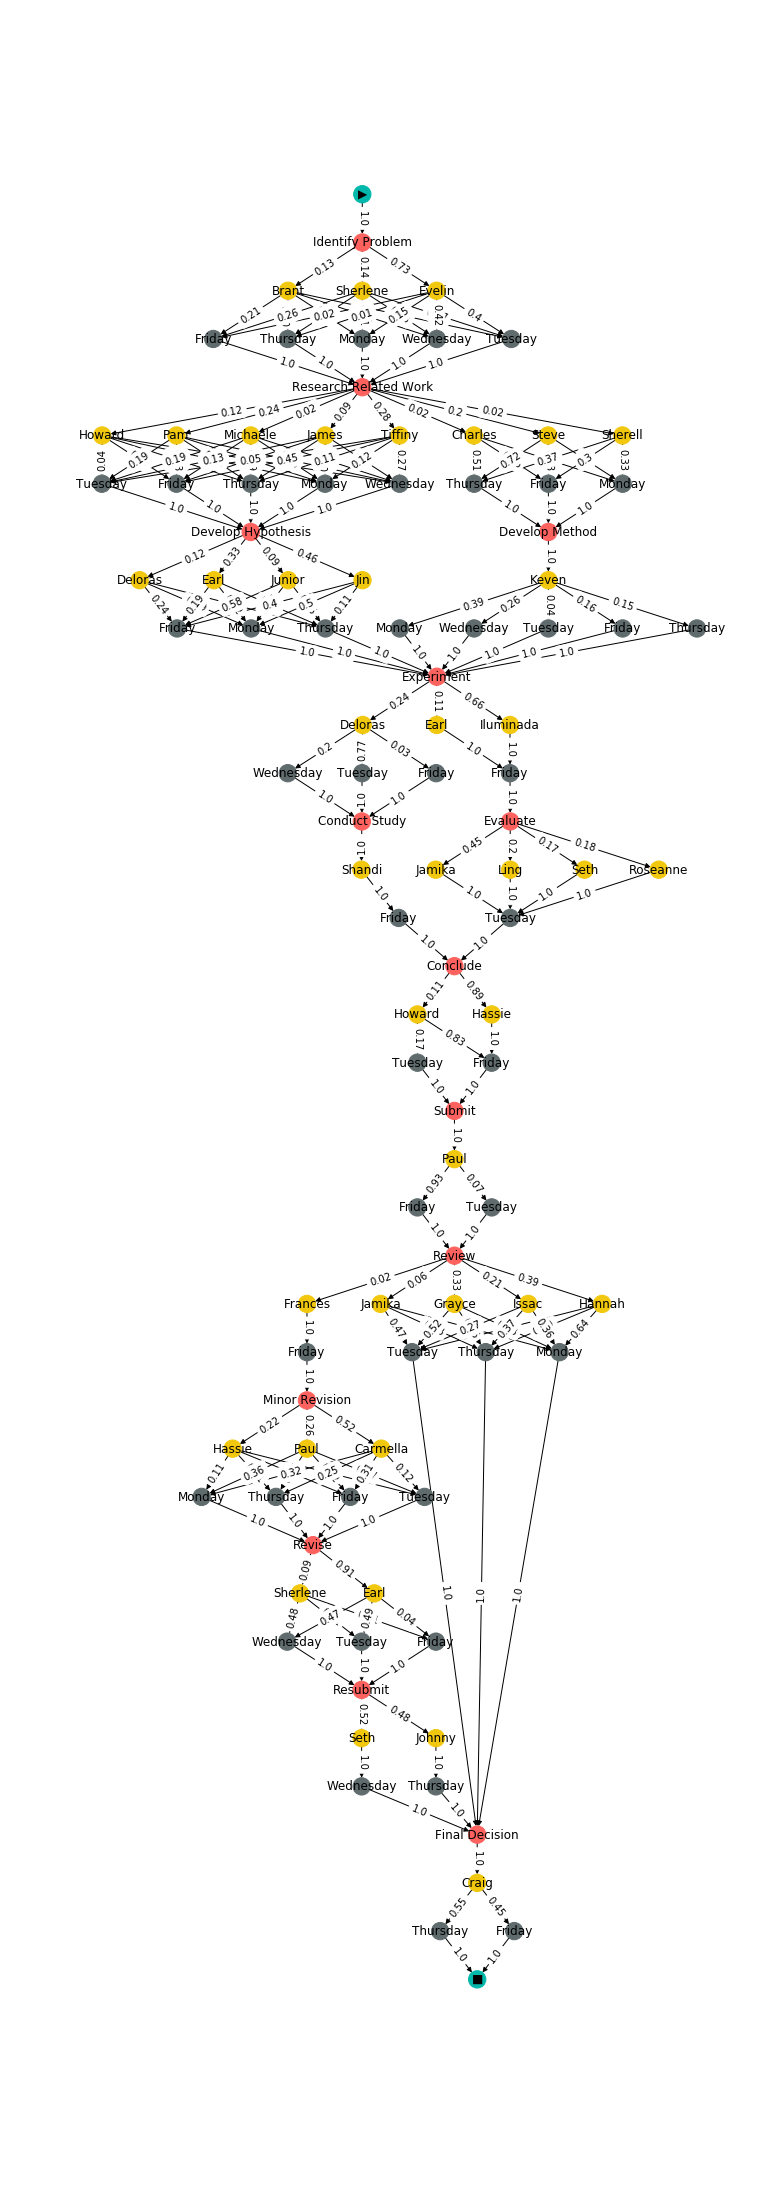

In [14]:
likelihood_graph = generator.build_likelihood_graph(activity_dependency_p=0.0,
                                                    attribute_dependency_p=0.5,
                                                    probability_variance_max=10,
                                                    seed=seed)
generator.plot_likelihood_graph(figsize=(10, 30))

Now we find that some of the attribute combinations are dropped, resulting in some subgraphs not being fully-meshed. This introduces attribute dependencies.

### Putting it all together
Now let us combine the parameters and look at the result.

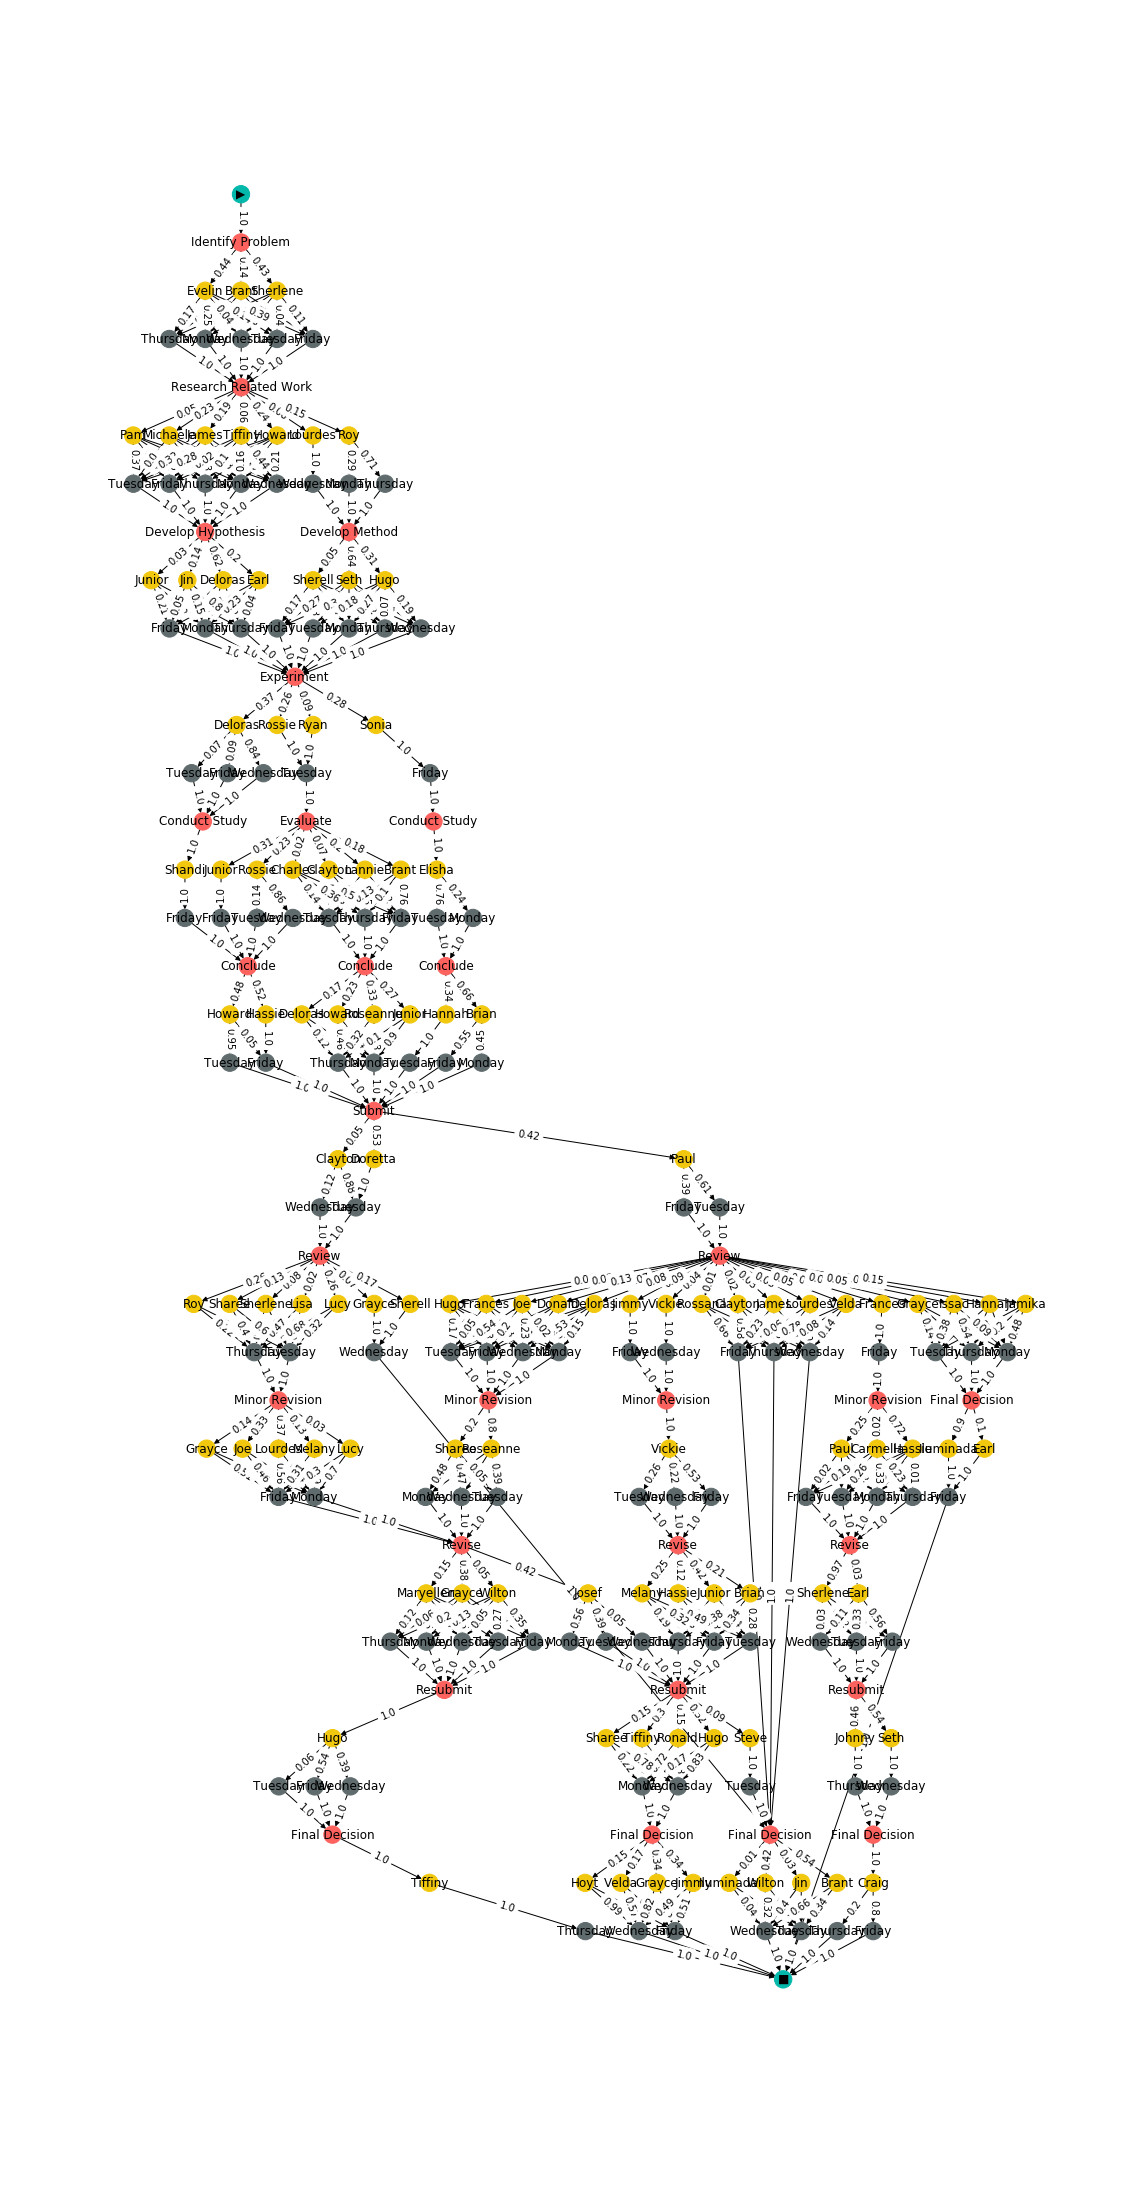

In [15]:
likelihood_graph = generator.build_likelihood_graph(activity_dependency_p=0.5,
                                                    attribute_dependency_p=0.5,
                                                    probability_variance_max=10,
                                                    seed=seed)
generator.plot_likelihood_graph(figsize=(15, 30))

In the resulting likelihood graph, we can see that there are multiple `Final Decision` nodes. Because these nodes depend on the path through the graph and the attributes connected to the different nodes are independent, we obtain activity dependencies. The path through the graph will determine the possible set of attribute values for a given activity node.